In [ ]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [ ]:
# Reading the dataset
url = r"https://raw.githubusercontent.com/pavanibillapati/SMS-spam-detection/main/spam.csv"
messages = pd.read_csv(url, sep=',', encoding='ISO-8859-1')
messages[:3]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [ ]:
messages = messages.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
messages = messages.rename(columns={"v1":"label", "v2":"message"})
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
# To display the duplicate rows
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


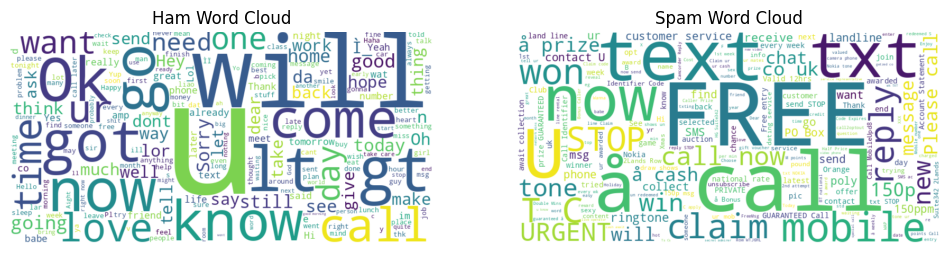

In [ ]:
# Get all the ham and spam emails
ham_messages = messages[messages['label'] == 'ham']
spam_messages = messages[messages['label'] == 'spam']

# Combine the messages into strings
ham_text = " ".join(ham_messages['message'].to_numpy())
spam_text = " ".join(spam_messages['message'].to_numpy())

# Create numpy arrays for visualization using word cloud
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Visualize the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
#To checke whether data is balanced or not
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

15.481865284974095

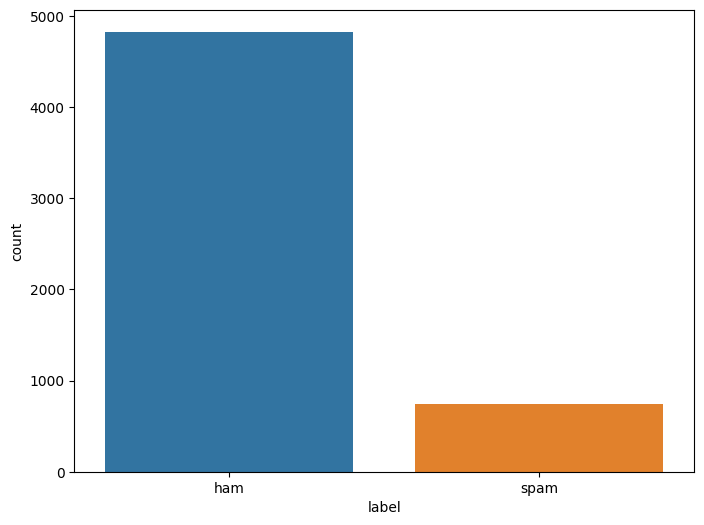

In [ ]:
# we can observe imbalance data here
plt.figure(figsize=(8,6))
sns.countplot(x=messages.label,data=messages)
# Percentage of spam messages
(len(spam_messages)/len(ham_messages))*100

In [ ]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_messages.sample(n = len(spam_messages), random_state = 44)
spam_msg_df = spam_messages
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


<ipython-input-12-9b96fce63e81>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


Text(0.5, 0, 'Message types')

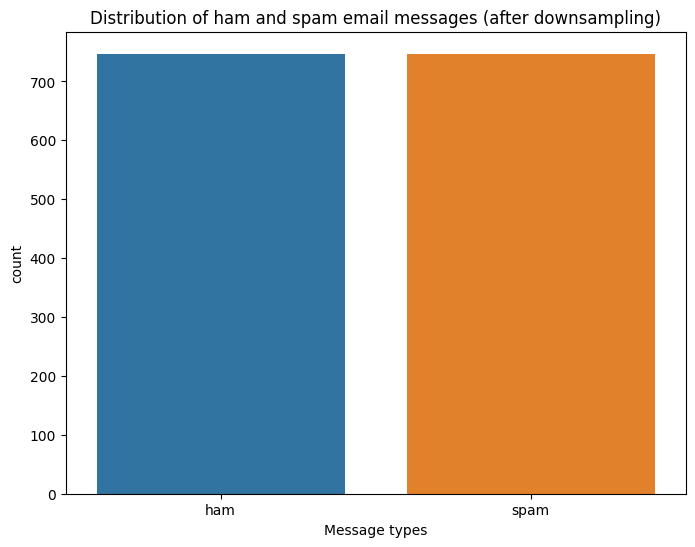

In [ ]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(x=msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

# Calculate average length by label types
average_length_by_label = msg_df.groupby('label')['text_length'].mean()

# Display the results
print(average_length_by_label)


label
ham      69.626506
spam    138.866131
Name: text_length, dtype: float64


In [ ]:
# Map ham label as 0 and spam as 1
msg_df['msg_type'] = msg_df['label'].map({'ham': 0, 'spam': 1})

# Extract features (messages) and labels
features = msg_df['message']
labels = msg_df['msg_type'].values

# Split data into train and test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)


In [ ]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

In [ ]:
# Initialize the tokenizer
vocab_size = 500  # Set your desired vocabulary size
oov_tok = '<OOV>'  # Out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)

# Fit the tokenizer on the training messages
tokenizer.fit_on_texts(train_features)

# Get the word_index
word_index = tokenizer.word_index

# Display the number of unique words in the vocabulary
num_unique_words = len(word_index)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 4110


In [ ]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'is': 11,
 'and': 12,
 'free': 13,
 'now': 14,
 'have': 15,
 '2': 16,
 'or': 17,
 'in': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 '4': 22,
 'txt': 23,
 'are': 24,
 'from': 25,
 'me': 26,
 'with': 27,
 'text': 28,
 'get': 29,
 'this': 30,
 'it': 31,
 'stop': 32,
 'mobile': 33,
 'my': 34,
 'just': 35,
 'claim': 36,
 'reply': 37,
 'be': 38,
 'we': 39,
 'only': 40,
 'do': 41,
 'that': 42,
 'will': 43,
 'at': 44,
 'www': 45,
 'out': 46,
 'no': 47,
 'so': 48,
 'can': 49,
 'if': 50,
 'send': 51,
 'not': 52,
 'cash': 53,
 'prize': 54,
 'our': 55,
 'go': 56,
 'new': 57,
 't': 58,
 'please': 59,
 'up': 60,
 'won': 61,
 'all': 62,
 'but': 63,
 '1': 64,
 'win': 65,
 'who': 66,
 'uk': 67,
 'know': 68,
 '150p': 69,
 'want': 70,
 "i'm": 71,
 'nokia': 72,
 'been': 73,
 'gt': 74,
 'what': 75,
 'com': 76,
 'tone': 77,
 'week': 78,
 'urgent': 79,
 'msg': 80,
 'lt': 81,
 '50': 82,
 'good': 83,
 'by': 8

In [ ]:
# Tokenize and pad training sequences
training_sequences = tokenizer.texts_to_sequences(train_features)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Tokenize and pad testing sequences
testing_sequences = tokenizer.texts_to_sequences(test_features)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
# Before padding length
print(len(training_sequences[0]), len(training_sequences[1]))
# After padding length
print(len(training_padded[0]), len(training_padded[1]))

7 6
50 50


In [ ]:
vocab_size = 500 # As defined earlier
embedding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [ ]:
# Define Dense model architecture
dense_model = Sequential()
dense_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
dense_model.add(GlobalAveragePooling1D())
dense_model.add(Dense(n_dense, activation='relu'))
dense_model.add(Dropout(drop_value))
dense_model.add(Dense(1, activation='sigmoid'))
dense_model.summary()

# Compile the model
dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = dense_model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks=[early_stop], verbose=2)

# Save the model
dense_model.save('Dense_Spam_Detection.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2
# Define LSTM Spam detection architecture
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
lstm_model.add(LSTM(n_lstm, dropout=drop_lstm))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.summary()

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the LSTM spam detection model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = lstm_model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels), callbacks=[early_stop], verbose=2)

# Save the model
lstm_model.save('LSTM_Spam_Detection.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 20)                2960      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 10981 (42.89 KB)
Trainable params: 10981 (42.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
38/38 - 5s - loss: 0.6927 - accuracy: 0.5456 - val_loss: 0.6883 - val_accuracy: 0.5987 - 5s/epoch - 125ms/step
Epoch 2/30
38/38 - 1s - loss: 0.5276 - accuracy: 0.7339 - val_loss: 0.3041 - val_accuracy: 0.9030 - 841ms/epoch - 22ms/step
Epoch 3/30
38/38 - 1s - loss: 0.2526

In [ ]:
# Biderectional LSTM Spam detection architecture
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
bidirectional_lstm_model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
bidirectional_lstm_model.add(Dense(1, activation='sigmoid'))
bidirectional_lstm_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history = bidirectional_lstm_model.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
bidirectional_lstm_model.save('BiLSTM_Spam_Detection.h5')

Epoch 1/30
38/38 - 7s - loss: 0.6863 - accuracy: 0.6025 - val_loss: 0.6621 - val_accuracy: 0.8629 - 7s/epoch - 191ms/step
Epoch 2/30
38/38 - 1s - loss: 0.5354 - accuracy: 0.8360 - val_loss: 0.4017 - val_accuracy: 0.8863 - 1s/epoch - 35ms/step
Epoch 3/30
38/38 - 1s - loss: 0.3001 - accuracy: 0.9063 - val_loss: 0.1975 - val_accuracy: 0.9264 - 1s/epoch - 35ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1194 - accuracy: 0.9640 - val_loss: 0.1671 - val_accuracy: 0.9365 - 1s/epoch - 33ms/step
Epoch 5/30
38/38 - 2s - loss: 0.0932 - accuracy: 0.9732 - val_loss: 0.1433 - val_accuracy: 0.9565 - 2s/epoch - 46ms/step
Epoch 6/30
38/38 - 2s - loss: 0.0735 - accuracy: 0.9749 - val_loss: 0.1536 - val_accuracy: 0.9498 - 2s/epoch - 62ms/step
Epoch 7/30
38/38 - 2s - loss: 0.0741 - accuracy: 0.9782 - val_loss: 0.1508 - val_accuracy: 0.9532 - 2s/epoch - 52ms/step
Epoch 8/30
38/38 - 1s - loss: 0.0406 - accuracy: 0.9908 - val_loss: 0.1526 - val_accuracy: 0.9565 - 1s/epoch - 33ms/step
Epoch 9/30
38/38 - 1s - loss: 0

In [ ]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {dense_model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {lstm_model.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {bidirectional_lstm_model.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1424 - accuracy: 0.9599
Dense architecture loss and accuracy: [0.1424040049314499, 0.9598662257194519] 
10/10 [==============================] - 0s 6ms/step - loss: 0.1673 - accuracy: 0.9532
LSTM architecture loss and accuracy: [0.16733580827713013, 0.953177273273468] 
10/10 [==============================] - 0s 9ms/step - loss: 0.1813 - accuracy: 0.9465
Bi-LSTM architecture loss and accuracy: [0.1813274770975113, 0.9464883208274841] 


**Scenario 1: Using raw text from our data:**

In [ ]:
# display long string
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (dense_model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 139ms/step


array([[0.01186293],
       [0.02574334],
       [0.9989698 ]], dtype=float32)

**Scenario 2: Using newly created text message and see how the model classifies them**

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 29ms/step


array([[0.7814135 ],
       [0.03495146],
       [0.01337497]], dtype=float32)